### Variational Autoencoders (VAEs): A Brief Explanation

1. Encoder: The encoder network maps input data to the parameters of a probability distribution (typically Gaussian). It produces both the mean and the variance  of the distribution.

2. Sampler: A sampling layer generates random samples from the learned distribution, introducing stochasticity into the encoding process. It's important for the training of VAEs.

3. Decoder: The decoder takes the sampled encoding and reconstructs the original input. The decoder is trained to generate data that is likely to be sampled from the learned distribution.

Training Objective: VAEs are trained to minimize two components of the loss:
- Reconstruction Loss: Measures how well the model reconstructs the input data.
- KL Divergence Loss: Encourages the learned distribution to be close to a predefined distribution (usually a standard normal distribution).



### Applications of VAEs:

1. Image Generation: VAEs are widely used for generating new, realistic images. They can create diverse samples by sampling from the latent space.

2. Data Imputation: VAEs can be used to fill in missing or corrupted parts of data, making them valuable for tasks involving incomplete datasets.

3. Anomaly Detection: By learning the distribution of normal data, VAEs can identify anomalies or outliers in new data that deviate significantly from the learned distribution.

4. Style Transfer: VAEs can be applied to transfer styles between images, creating artistic effects.

5. Drug Discovery: In molecular biology, VAEs have been employed to generate novel chemical structures with desired properties for drug discovery.

6. Representation Learning: VAEs learn a meaningful representation of the input data, making them valuable for downstream tasks like classification and clustering.

7. Sequential Data Modeling: VAEs can be extended to model sequential data, such as time series or sequences of text.

8. Domain Adaptation: VAEs can be used to learn representations that are invariant across different domains, aiding in domain adaptation tasks.



### Key Advantages:

1. Generative Modeling: VAEs are generative models, capable of generating new samples from the learned distribution.

2. Continuous Latent Space: The continuous and smooth latent space of VAEs enables meaningful interpolations between data points.

3. Stochasticity: The sampling layer introduces stochasticity during training, making VAEs more robust and capable of generating diverse samples.

4. Regularization: The KL divergence term in the loss function acts as a regularization term, helping prevent overfitting.

Variational Autoencoders are a versatile class of models with applications across various domains, making them a powerful tool for researchers and practitioners in machine learning and artificial intelligence.

Let's use CIFAR Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K


In [3]:
# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [4]:
# Normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

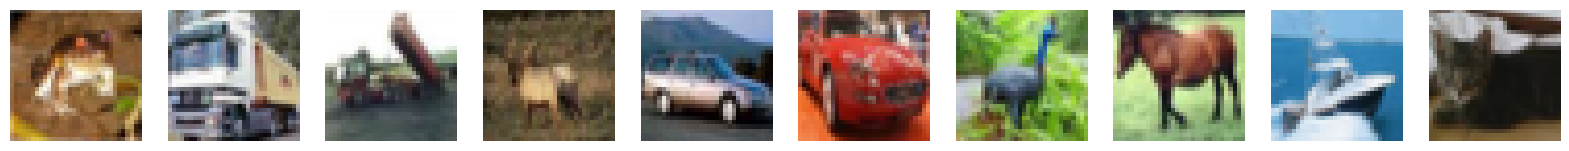

In [5]:
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_train[i])
    plt.axis('off')

plt.show()

In [6]:
# Flatten the images
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [7]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# VAE Architecture

In [8]:
# Define VAE architecture for color images
def build_color_vae(input_dim, encoding_dim):
    # Encoder
    inputs = Input(shape=(input_dim,))
    h = Dense(512, activation='relu')(inputs)
    z_mean = Dense(encoding_dim)(h)
    z_log_var = Dense(encoding_dim)(h)

    # Sampler
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, output_shape=(encoding_dim,))([z_mean, z_log_var])

    # Decoder
    decoder_h = Dense(512, activation='relu')
    decoder_mean = Dense(input_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    # Reshape for color images
    x_decoded_mean = Reshape((32, 32, 3))(x_decoded_mean)

    # Build the VAE model
    vae = Model(inputs, x_decoded_mean)

    # Define the VAE loss
    xent_loss = input_dim * tf.keras.losses.binary_crossentropy(Flatten()(inputs), Flatten()(x_decoded_mean))
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    # Encoder model, for latent space visualization
    encoder = Model(inputs, z_mean)

    return vae, encoder


In [9]:
# Set parameters
input_dim = 32 * 32 * 3  # 32x32 pixels, 3 channels (RGB)
encoding_dim = 64  # Example: 64-dimensional latent space

In [10]:
# Build VAE model for color images
color_vae_model, color_encoder_model = build_color_vae(input_dim, encoding_dim)

In [11]:
# Train the VAE for color images
color_vae_model.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/50
196/196 [==============================] - 36s 177ms/step - loss: 1993.0245 - val_loss: 1935.9705
Epoch 2/50
196/196 [==============================] - 28s 143ms/step - loss: 1911.7885 - val_loss: 1902.7302
Epoch 3/50
196/196 [==============================] - 28s 143ms/step - loss: 1890.6580 - val_loss: 1887.1443
Epoch 4/50
196/196 [==============================] - 31s 156ms/step - loss: 1878.9053 - val_loss: 1877.8392
Epoch 5/50
196/196 [==============================] - 28s 143ms/step - loss: 1870.6646 - val_loss: 1870.4746
Epoch 6/50
196/196 [==============================] - 28s 143ms/step - loss: 1865.5499 - val_loss: 1866.9635
Epoch 7/50
196/196 [==============================] - 28s 143ms/step - loss: 1861.7655 - val_loss: 1863.0596
Epoch 8/50
196/196 [==============================] - 28s 145ms/step - loss: 1858.6537 - val_loss: 1861.4254
Epoch 9/50
196/196 [==============================] - 28s 144ms/step - loss: 1856.4059 - val_loss: 1859.3254
Epoch 10/50
196/196

In [12]:
# Encode and decode some color images
encoded_color_imgs = color_encoder_model.predict(x_test)
decoded_color_imgs = color_vae_model.predict(x_test)

313/313 [==============================] - 4s 12ms/step


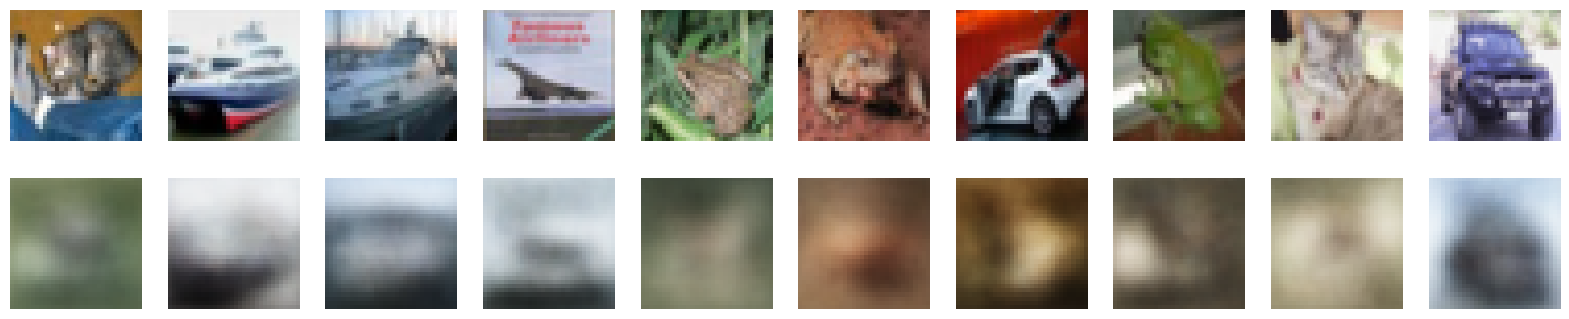

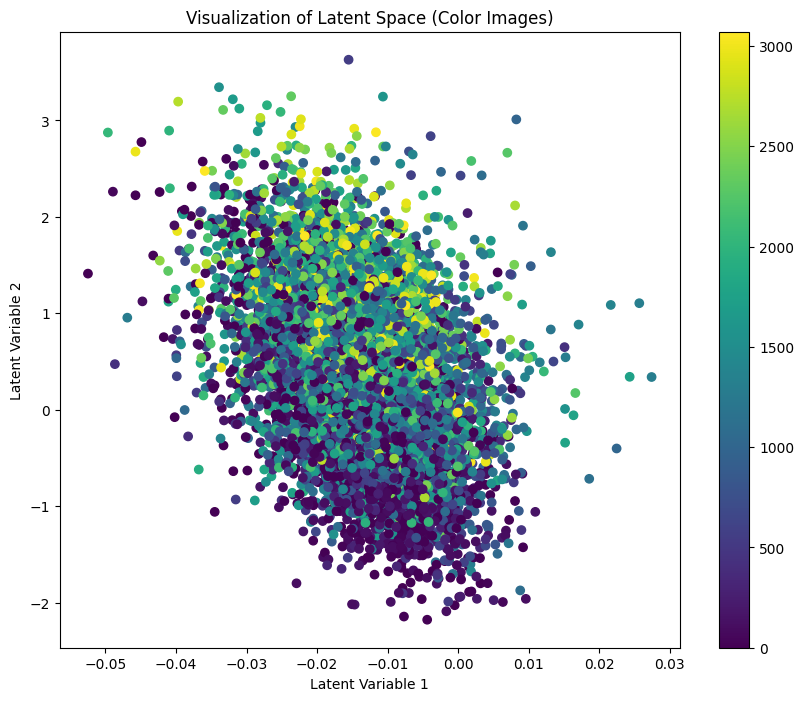

In [13]:
# Plot original and reconstructed color images
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original color images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.axis('off')

    # Reconstructed color images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_color_imgs[i].reshape(32, 32, 3))
    plt.axis('off')

plt.show()

# Visualize the latent space for color images
plt.figure(figsize=(10, 8))
plt.scatter(encoded_color_imgs[:, 0], encoded_color_imgs[:, 1], c=np.argmax(x_test, axis=1), cmap='viridis')
plt.colorbar()
plt.title('Visualization of Latent Space (Color Images)')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.show()
